 # **Spendl - Data Analysis Report**

In [19]:
#importing packages
import pandas as pd
import geopandas as gpd
import bokeh 
import plotly

from plotly.offline import download_plotlyjs, init_notebook_mode,  iplot
init_notebook_mode(connected=True)

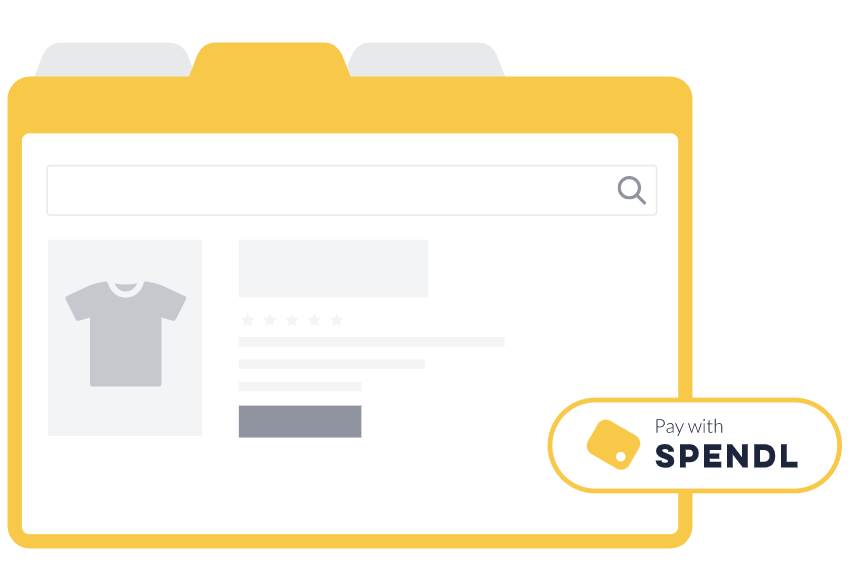

**This report will inspect, visualize and model Spendl's transaction data with the goal of discovering useful information and identifying relevant trends.  The report will be divided into sections and will cover a wide variety of features and parameters that will help enhance operational efficiency and support business decision-making in the future.** 

## Table of Contents

* [1. Geographic Analysis](#chapter1)
    * [1.1. Country](#section_1_1)
    * [1.2. Continent](#section_1_2)
    * [1.3. Interactive Map](#section_1_3)
* [2. Chronological Analysis](#chapter2)
    * [2.1. Transactions per Date](#section_2_1)
    * [2.2. Amount of EUR spent per Date](#section_2_2)

The report is based on the following supplemental data:

In [20]:
spendl = pd.read_csv('/Users/amirgrunhaus/Documents/Internships/Spendl/Data/dw.csv')
spendl.head(3)

,Date,Amount of EUR,Fee,Rate,Amount of BTC,Is Lightning,Username,UserCreateDate,Country,Birthdate,Partner
0,2020-12-24 18:29:01,280.0,8.12,19160.278134,0.015037,False,05d6ecdc-adfc-4955-aa6a-021b909b8e81,2020-09-27 00:08:14.442000+03:00,NGA,1988-01-01T00:00:00,coinmama
1,2021-03-31 15:50:50,40.0,1.16,50390.538919,0.000817,True,110e959f-8bab-4dc9-a86e-3d7e859da809,2021-01-05 11:22:03.862000+02:00,CAN,1987-12-29T00:00:00,NaN
2,2021-03-31 09:13:41,9.0,0.99,49465.240642,0.000202,False,0c909175-d35c-4dc0-b007-ad3f99549bd4,2021-02-22 21:01:19.091000+02:00,JOR,1995-07-21T00:00:00,coinmama


#### **Every row represents a single transaction made with Spendl's virtual debit cards 
### **Column Description**
- **Date**: date of transaction
<br>
- **Amount of EUR**: amount of Euros spent in transaction
<br>
- **Fee**: fee charged by Spendl per transaction (EUR) 
<br>
- **Rate**: BTC to EUR exchange rate at the moment the transaction was made
<br>
- **Amount of BTC**: amount of BTC spent in transaction in accordance to exchange rate 
<br>
- **Is Lightning**: ??
<br>
- **Username**: who made the transaction 
<br>
- **UserCreateDate**: date the user account was created
<br>
- **Country**: user's country of origin
<br>
- **Birthdate**: user's date of birth 
<br>
- **Partner**: ??

## 1. Geographic Analysis <a class="anchor" id="chapter1"></a>

This section will inspect the supplemental data on a geographical basis. The goal of this section is to visualize geographical data and to identify relevant geographical trends. 

### 1.1. Country <a class="anchor" id="section_1_1"></a>

,Transactions per Country
DEU,130
CAN,128
COL,124
CZE,101
BGR,100
ISR,88
NLD,78
ROU,76
RUS,74
FRA,74


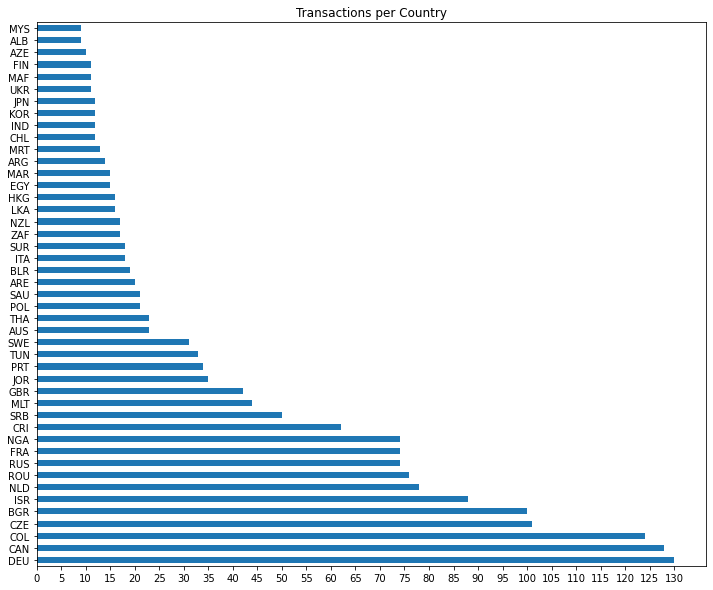

In [21]:
#Table and Bar Chart with Number of Transactions per Country

#Bar Chart
country_barh = spendl['Country'].value_counts()[:45].plot(kind='barh', title='Transactions per Country', xticks = list(range(131))[0::5], figsize = (12, 10))

#Table
country_count = spendl['Country'].value_counts().to_frame(name = 'Transactions per Country')
country_count.head(10)

### 1.2. Continent <a class="anchor" id="section_1_2"></a>

,Percentage
Europe,49.924812
Asia,18.997494
North America,11.127820
Africa,9.172932
South America,8.721805
Oceania,2.055138


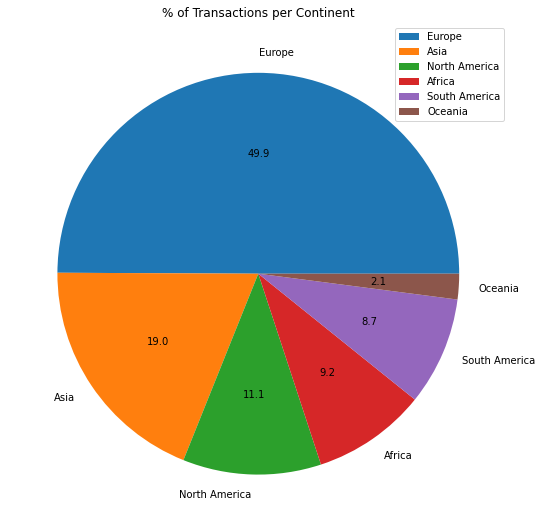

In [22]:
#Table and Pie Chart with % of Transactions per Continent

#Merge data with continent table
country_continent = pd.read_csv('/Users/amirgrunhaus/Documents/Internships/Spendl/Data/country_and_continent.csv')
spendl_country_continent = pd.merge(spendl, country_continent, left_on = 'Country', right_on = 'Three_Letter_Country_Code')

#Table
series_country_continent = spendl_country_continent['Continent_Name'].value_counts(normalize=True) * 100
df_country_continent = series_country_continent.to_frame()
df_country_continent = df_country_continent.rename(columns={'Continent_Name': 'Percentage'})

#Pie Chart
series_country_continent.plot(kind='pie',autopct='%.1f',fontsize=10, title='% of Transactions per Continent',legend=True,label="",figsize = (9, 9.5))

#Output Table
df_country_continent

### 1.3. Interactive Map <a class="anchor" id="section_1_3"></a>

The following interactive map is a 'Choropleth Map'; it displays a world map colored by country in relation to the number of transactions per country. If you move the cursor on top of the map you should be able to see the exact number of transactions per country. 

In [23]:
#Import Map
shapefile = '/Users/amirgrunhaus/Documents/Internships/Spendl/Data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]

#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])

#Rename columns
gdf.columns = ['country', 'country_code', 'geometry']

#Merge gdf with country_count
merged = gdf.merge(country_count, left_on = 'country_code', right_index=True)

#Perform left merge to preserve every row in gdf.
merged = gdf.merge(country_count, left_on = 'country_code', right_index=True, how = 'left')

#Fill in missing data
merged.fillna('0 / No Transactions Recorded', inplace = True)

#Read data to json
import json
merged_json = json.loads(merged.to_json())

#Convert to String like object
json_data = json.dumps(merged_json)

#Imports from bokeh 
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.models import Slider, HoverTool

#Input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]

#Reverse color order so that dark blue is highest number of transactions
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 131, nan_color = '#d9d9d9')

#Define custom tick labels for color bar
tick_labels = {'0': '1+', '20': '20', '40':'40', '60':'60', '80':'80', '100':'100', '131':'130'}

#Create color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('# of Transactions', '@{Transactions per Country}')])

#Create figure object
p = figure(title = 'Number of Transactions per Country', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Transactions per Country', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook
output_notebook()

#Display figure
show(p)

Loading BokehJS ...

## 2. Chronological Analysis <a class="anchor" id="chapter2"></a>

This section will inspect the data on a chronological basis. The goal of this section is to visualize different timelines to get a better understanding of the chronological nature of the transactions as well as to identify relevant chronological trends.

### 2.1. Transactions per Date  <a class="anchor" id="section_2_1"></a>

This sub-section includes an interactive timeline that shows the number of transactions per recorded date. By moving the cursor on top of the timeline, you should be able to see the exact number of transactions and the exact date when the transactions were made. 

In [24]:
#Table of Transactions per Date
date_frame = (pd.to_datetime(spendl['Date'])
       .dt.floor('d')
       .value_counts()
       .rename_axis('Date')
       .reset_index(name='Transactions'))
                         
#Sort Table
date_frame = date_frame.sort_values('Date')

#Interactive Line Plot
import plotly.graph_objects as go

#Create figure
fig1 = go.Figure()

fig1.add_trace(
    go.Scatter(x=list(date_frame.Date), y=list(date_frame.Transactions), marker=dict(size=20, color="blue")))

#Set title
fig1.update_layout(title_text="Total Number of Transactions per Date", title_font_size=20)

#Add range slider
fig1.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

### 2.2. Amount of EUR spent per Date <a class="anchor" id="section_2_2"></a>

This sub-section includes an interactive timeline that shows the total amount of Euros spent in all transactions made on the given date. By moving the cursor on top of the timeline, you should be able to see the total amount of Euros spent transactions and the exact date when the transactions were made. 

In [25]:
#Change date column to contain only date and no time
spendl['Date'] = pd.to_datetime(spendl['Date'], format = '%Y-%m-%d %H:%M:%S')
spendl['Date'] = spendl['Date'].dt.date

#Table of aggregated values (sum) per date 
date_sum = spendl.groupby('Date').sum()
date_sum = date_sum.drop(labels=['Rate', 'Is Lightning'], axis=1)

#Table of amount of EUR spent by user per day
date_sum_eur = date_sum['Amount of EUR']
date_sum_eur = date_sum_eur.to_frame()
date_sum_eur.reset_index(level=0, inplace=True)

#Interactive Line Plot
import plotly.graph_objects as go

#Create figure
fig2 = go.Figure()

fig2.add_trace(
    go.Scatter(x=list(date_sum_eur.Date), y=list(date_sum_eur['Amount of EUR']), marker=dict(size=20, color="blue")))

#Set title
fig2.update_layout(title_text="Amount of EUR spent in all Transactions per Date", title_font_size=20)

#Add range slider
fig2.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

In [26]:
iplot(fig1)

In [27]:
iplot(fig2)